### Step.1 환경 설정 및 라이브러리 import

In [1]:
import os
import json
import random
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models, applications
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications.densenet import preprocess_input
from tensorflow.keras.applications import DenseNet121

### Step.2 데이터 불러오기 및 전처리 과정

In [2]:
#학습용 데이터 불러오기

train_csv = './DeepPCB_split/trainval_label.csv'
df = pd.read_csv(train_csv)
train_image_dir = './DeepPCB_split/train'

#filepath -> csv 파일의 filename 열에 저장되어 있는 이미지 이름과 동일한 이미지의 실제 경로(폴더)를 filepath에 저장
#예를 들어, filename -> file1.jpg 이면서 train_image_dir이 './train_images'라면 './train_images/file1.jpg 형태로 저장된다
df['filepath'] = df['filename'].apply(lambda x: os.path.join(train_image_dir, x))
'''
| filename  | filepath                  |
| --------- | ------------------------- |
| file1.jpg | ./train\_images/file1.jpg |
| file2.jpg | ./train\_images/file2.jpg |
| file3.jpg | ./train\_images/file3.jpg |
'''
#model 학습에 사용하기 위해 각각의 열을 list화
#filepaths: 이미지 파일의 경로 리스트
#labels: 'Defect' 열을 기반으로 한 정답 라벨 리스트(정상은 0, 불량은 1로 구성)
filepaths = df['filepath'].tolist()
labels = df['Defects'].tolist()

#테스트용 데이터 불러오기
test_csv = './DeepPCB_split/test_label.csv'
test_df = pd.read_csv(test_csv)
test_dir = './DeepPCB_split/test'

test_df['filepath'] = test_df['filename'].apply(lambda x: os.path.join(test_dir, x))

test_filepaths = test_df['filepath'].tolist()
test_labels = test_df['Defects'].tolist()


IMG_SIZE = 224  # CNN에서 보통 사용하는 표준 크기
BATCH_SIZE = 32 # 한 번의 모델 가중치 업데이트에 사용되는 개수

#decode_img: 이미지 경로 -> 실제 이미지 tensor로 변환하는 전처리 함수
#위 함수를 tf.data.Dataset에 연결해서 학습에 쓸 최종 데이터를 만든다.
def decode_img(img_path, label):  
    # 이미지 경로로 읽기
    img = tf.io.read_file(img_path)
    # JPEG 디코딩, 흑백 이미지이므로 channels = 1
    img = tf.image.decode_jpeg(img, channels=1)
    #명시적 형 변환(float 32)
    img = tf.image.convert_image_dtype(img, tf.float32)
    # 이미지 크기 재지정
    img = tf.image.resize(img, [IMG_SIZE, IMG_SIZE])
    return img, label

### Step.3 학습 데이터셋 구성(학습 / 검증 / 테스트)

In [3]:
#리스트 분할(80% 학습, 20% 검증)
train_files, val_files, train_labels, val_labels = train_test_split(
    filepaths, labels, test_size=0.2, random_state=42, stratify=labels
)

#Dataset 만들기
#학습용 Dataset
train_dataset = tf.data.Dataset.from_tensor_slices((train_files, train_labels))
train_dataset = train_dataset.map(decode_img, num_parallel_calls=tf.data.AUTOTUNE)
train_dataset = train_dataset.shuffle(1000).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
#검증용 Dataset
val_dataset = tf.data.Dataset.from_tensor_slices((val_files, val_labels))
val_dataset = val_dataset.map(decode_img, num_parallel_calls=tf.data.AUTOTUNE)
val_dataset = val_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
#테스트용 Dataset
test_dataset = tf.data.Dataset.from_tensor_slices((test_filepaths, test_labels))
test_dataset = test_dataset.map(decode_img, num_parallel_calls=tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

### Step.4 모델 정의 및 학습 & 시각화
* 총 5단계의 나누어서 모델을 학습, 결과 평가
* 각 모델에 대한 설명은 코드 위 마크다운을 통해 작성
* 모델 학습 이후 테스트 데이터셋을 이용해 모델의 loss 및 accuracy를 계산(여기서는 accuracy 결과만 저장하여 추후 시각화에 사용)

### <Version.1>
* 기본적인 CNN 구조의 version.1 모델
* 4개의 Conv-Pooling 블록으로 feature를 추출하고, Flatten 및 Dense 계층을 통해 2개의 클래스를 분류하는 모델(정상, 불량)
* 두 클래스 중 더 높은 확률을 가진 클래스를 선택하는 방식

In [4]:
EPOCH = 30

#model_1 : softmax + sparse_categorical_crossentropy, 출력층 2개
model = models.Sequential([
    layers.InputLayer(input_shape=(IMG_SIZE, IMG_SIZE, 1)),
    
    layers.Conv2D(16, 3, activation='relu'),
    layers.MaxPooling2D(2),
    
    layers.Conv2D(32, 3, activation='relu'),
    layers.MaxPooling2D(2),
    
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(2),
    
    layers.Conv2D(128, 3, activation='relu'),
    layers.MaxPooling2D(2),
    
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(2, activation='softmax')
])
model.summary()
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
#모델 학습
history_1 = model.fit(train_dataset,
                    validation_data=val_dataset,
                    epochs = EPOCH
                    )

result = model.evaluate(test_dataset)
accuracy_type1 = result[1]

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 16)      160       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 54, 54, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 52, 52, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 26, 26, 64)       0

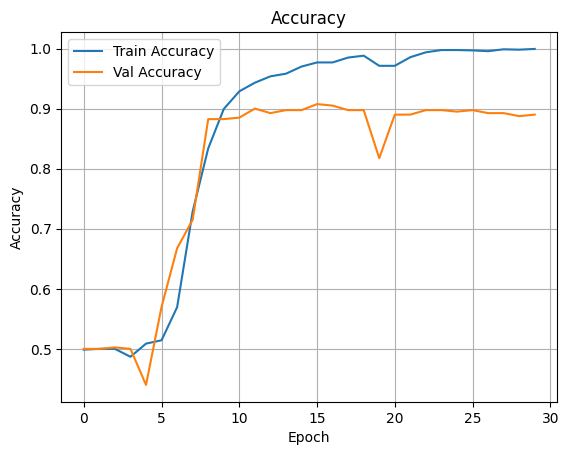

In [5]:
#Train Accuracy, Val Accuracy 비교
plt.plot(history_1.history['accuracy'], label='Train Accuracy')
plt.plot(history_1.history['val_accuracy'], label='Val Accuracy')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

### <Version.2>
* 이전 코드의 경우 정확도는 높은 편이었지만 과적합 문제 발생
* 에폭 수를 넉넉히 잡되 EarlyStopping, ReduceLROnPlateau 라이브러리를 이용한 콜백 함수를 작성해 과적합이 일어나기 전의 에폭까지만 학습하도록 조정
* 이진 분류에 좀 더 적절한 손실 함수(binary_crossentropy) 및 활성화 함수(sigmoid) 사용

In [6]:
#에폭 수 30 -> 100으로 조정
EPOCH = 100

#콜백함수 지정
early_stop = EarlyStopping(monitor='val_loss', patience=10, min_delta = 0.0005, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1)

#model_2 : sigmoid + binary_crossentropy, 출력층 1개
model = models.Sequential([
    layers.InputLayer(input_shape=(IMG_SIZE, IMG_SIZE, 1)),

    layers.Conv2D(16, 3, activation='relu'),
    layers.MaxPooling2D(2,2),

    layers.Conv2D(32, 3, activation='relu'),
    layers.MaxPooling2D(2,2),
    
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(2,2),
    
    layers.Conv2D(128, 3, activation='relu'),
    layers.MaxPooling2D(2,2),
    
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')
])
model.summary()
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])


#모델 학습
history_2 = model.fit(train_dataset,
                    validation_data=val_dataset,
                    epochs = EPOCH,
                    callbacks=[early_stop, reduce_lr]
                    )

result = model.evaluate(test_dataset)
accuracy_type2 = result[1]

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 222, 222, 16)      160       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 111, 111, 16)     0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 109, 109, 32)      4640      
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 54, 54, 32)       0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 52, 52, 64)        18496     
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 26, 26, 64)      

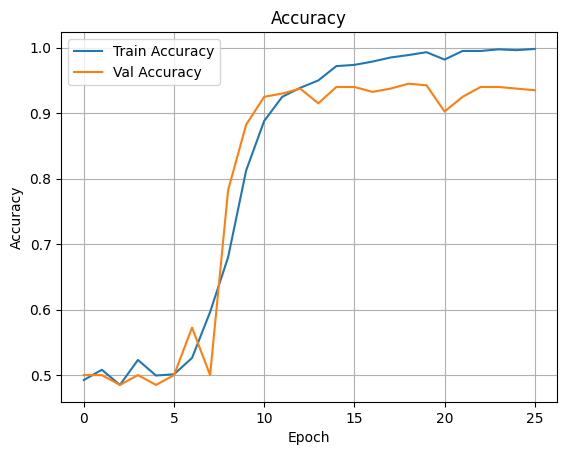

In [7]:
#Train Accuracy, Val Accuracy 비교
plt.plot(history_2.history['accuracy'], label='Train Accuracy')
plt.plot(history_2.history['val_accuracy'], label='Val Accuracy')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

<Version.3>
* 기존의 CNN 방식도 높은 성능을 보였지만, 다른 모델도 탐구해보기 위해 Data Augmentation 방식으로 모델을 생성
* Data Augmentation: 훈련 데이터 다양성을 증가시켜(이미지를 회전시키거나 확대하는 등) 과적합을 방지하면서 일반화를 향상시키는 방식
* 기본적인 틀은 Version.2를 유지

In [8]:
#model_3 : Data Augmentation을 이용한 학습법

#콜백 함수 조정(factor 0.5 -> 0.3 조정)
early_stop = EarlyStopping(monitor='val_loss', patience=10, min_delta=0.0005, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=5, min_lr=1e-6, verbose=1)

#data augmentation layer 정의(다양성을 증가시켜 과적합 방지 및 성능 증가 기대)
data_augmentation = models.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.02),      # ±5도 회전 (구조 뒤틀림 방지)
    layers.RandomZoom(0.03),          # ±5% 줌 (모서리 정보 손실 방지)
    layers.RandomContrast(0.02),      # 대비 거의 유지 (원본이 고대비)
    layers.RandomTranslation(0.03, 0.03)  # ±5% 범위만 이동
])

def augment(image, label):
    image = data_augmentation(image)
    return image, label

augmented_train_dataset = train_dataset.map(augment)

model = models.Sequential([
    layers.Input(shape=(IMG_SIZE, IMG_SIZE, 1)),

    layers.Conv2D(16, 3, activation='relu'),
    layers.MaxPooling2D(2,2),

    layers.Conv2D(32, 3, activation='relu'),
    layers.MaxPooling2D(),

    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),

    layers.Conv2D(128, 3, activation='relu'),
    layers.MaxPooling2D(),

    layers.Flatten(),
    layers.Dropout(0.5),
    layers.Dense(128, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])


model.summary()
model.compile(
    optimizer='Adam', 
    loss='binary_crossentropy',
    metrics=['accuracy']
)

history_3 = model.fit(
    augmented_train_dataset,
    validation_data=val_dataset,
    epochs=EPOCH,
    callbacks=[early_stop, reduce_lr]
)

result = model.evaluate(test_dataset)
accuracy_type3 = result[1]

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 222, 222, 16)      160       
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 111, 111, 16)     0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 109, 109, 32)      4640      
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 54, 54, 32)       0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 52, 52, 64)        18496     
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 26, 26, 64)      

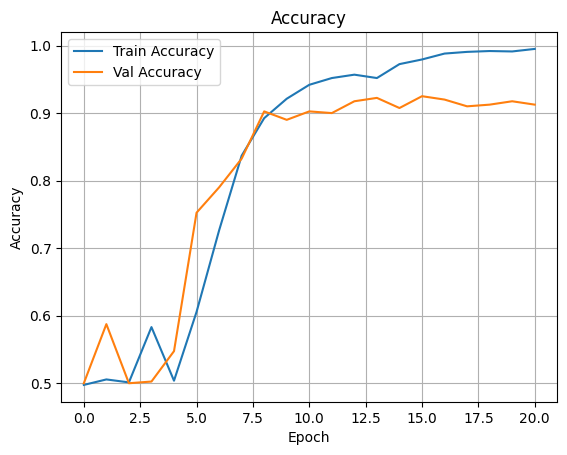

In [9]:
#Train Accuracy, Val Accuracy 비교
plt.plot(history_3.history['accuracy'], label='Train Accuracy')
plt.plot(history_3.history['val_accuracy'], label='Val Accuracy')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

### model_4 -> residual connections를 추가하여 정보 손실을 방지하는 모델
* 몇 개의 층을 건너뛰는 연결(shortcut = layers.Conv2D(filters, (1, 1), padding="same")(x)을 하나 만들어
* 다음 층들의 채널 수(filter)와 맞춰주어 덧셈연산이 가능하게 함
* 모델의 층이 깊어질 수록 정보가 소실되는 문제(기울기 소실, 과적합 등..)가 발생 할 수 있기에
<br> ADD 연산을 통해 입력이 그대로 다음 층으로 전달되고 층을 추가해도 성능이 나빠지지 않게 할 수 있음

In [16]:
#model_4 -> residual connections를 추가하여 정보 손실을 방지하는 모델
# 몇 개의 층을 건너뛰는 연결(shortcut = layers.Conv2D(filters, (1, 1), padding="same")(x)을 하나 만들어
# 다음 층들의 채널 수(filter)와 맞춰주어 덧셈연산이 가능하게 함
# 모델의 층이 깊어질 수록 정보가 소실되는 문제(기울기 소실, 과적합 등..)가 발생 할 수 있기에
# ADD 연산을 통해 입력이 그대로 다음 층으로 전달되고 층을 추가해도 성능이 나빠지지 않게 할 수 있음
def residual_block(x, filters):
    # shortcut 경로 : 입력 x 의 채널 수를 filters와 동일하게 맞춤
    shortcut = layers.Conv2D(filters, (1, 1), padding="same")(x)  # 크기 맞추기

    # 주 경로 : 3x3 컨볼루션 두 번
    x = layers.Conv2D(filters, (3, 3), padding='same', activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(filters, (3, 3), padding='same')(x)
    x = layers.BatchNormalization()(x)

    # shortcut과 주 경로를 더함
    x = layers.Add()([x, shortcut])  # 동일한 크기로 유지
    x = layers.ReLU()(x)

    return x

# Model 4: ResNet 구조
input_layer = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 1))
x = layers.Conv2D(64, (3,3), activation='relu', padding="same")(input_layer)
x = layers.BatchNormalization()(x)

x = residual_block(x, 64)
x = layers.MaxPooling2D()(x)

x = residual_block(x, 128)
x = layers.MaxPooling2D()(x)

x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(0.6)(x)  # 드롭아웃 수치 (0.5 -> 0.6)
output_layer = layers.Dense(2, activation='softmax')(x)


early_stop = EarlyStopping(monitor='val_loss',patience=15, restore_best_weights=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=7, min_lr=1e-8, verbose=1)

model_4 = models.Model(inputs=input_layer, outputs=output_layer)
model_4.compile(optimizer='adam',
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])

# 모델 학습
model_4.summary()
history_4 = model_4.fit(train_dataset,
                        validation_data=val_dataset,
                        epochs=EPOCH,
                        callbacks=[early_stop, reduce_lr]
                        )

result = model.evaluate(test_dataset)
accuracy_type4 = result[1]

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_8 (InputLayer)           [(None, 224, 224, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_26 (Conv2D)             (None, 224, 224, 64  640         ['input_8[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_10 (BatchN  (None, 224, 224, 64  256        ['conv2d_26[0][0]']              
 ormalization)                  )                                                           

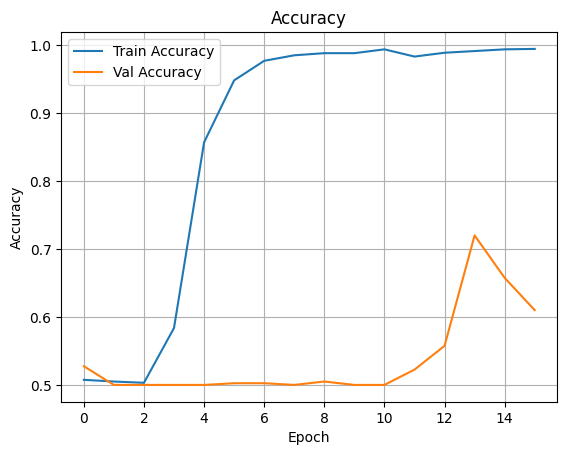

In [17]:
#Train Accuracy, Val Accuracy 비교
plt.plot(history_4.history['accuracy'], label='Train Accuracy')
plt.plot(history_4.history['val_accuracy'], label='Val Accuracy')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

### DenseNet121 모델을 백본으로 사용한 CNN모델
* DenseNet121 모델을 백본으로 사용하여 이 모델의 가중치를 초기값으로 사용
* 모델의 학습 가능 상태로 설정하여 미세 조정(Fine-tuning)을 통해 PCB데이터에 더 적합하도록 함
* 기존 DenseNet121모델의 최상단 분류층을 제거 (include_top=False)하고 새로운 분류기 추가
* DenseNet121의 출력을 받아 GlobalAveragePooling2D(Flatten과 비슷)를 거친 후 두 개의 Dense layer <br>(각 128, 256 노드, ReLu 활성화, 0.5, 0.6의 드롭아웃)을 포함하는 헤드 구성 최종출력에서 softmax함수로 분류
* 콜백 함수 (Earlystopping) - 검증 손실이 10 Epoch동안 개선되지 않으면 학습을 조기 중단하고 최적의 가중치 복원,<br> 스케줄러 (ReduceLROnPlateau)  검증 손실이 7 Epoch 동안 개선되지 않으면 학습률을 10% 감소시키는 스케줄러를 사용

In [ ]:
# 입력 레이어 정의 (흑백 이미지이므로 1채널)
input_layer = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 1)) #1 채널 흑백 이미지 입력

x = layers.Lambda(tf.image.grayscale_to_rgb)(input_layer) # 흑백을 RGB로 변환 (0-1 범위 유지)

x = layers.RandomFlip("horizontal")(x)
x = layers.RandomRotation(0.1)(x)            # ±10% 회전 (구조 뒤틀림 방지)
x = layers.RandomZoom(0.1)(x)                # ±10% 확대/축소 (모서리 정보 손실 방지)
x = layers.RandomContrast(0.1)(x)            # 대비 거의 유지 (원본이 고대비)
x = layers.RandomTranslation(height_factor=0.1, width_factor=0.1)(x) # ±10% 범위만 이동

x = layers.Lambda(lambda img: img * 255.0)(x) # 0-1 범위의 픽셀 값을 다시 0-255 범위로 되돌림
x = layers.Lambda(preprocess_input)(x)        # DenseNet121 모델이 요구하는 전처리 적용 
                                              # (픽셀 값 정규화 등..)

# 사전 학습된 DenseNet121 모델 불러오기
base_model = applications.DenseNet121(input_shape=(IMG_SIZE, IMG_SIZE, 3),# 3채널 이미지 입력 지정 (베이스 모델은 꼭 3채널 입력 받아야함)
                                      include_top=False,                  # imageNet 데이터셋의 학습된 가중치 사용
                                      weights='imagenet')                 # 2개 클래스에 맞게 새로운 분류기 추가
base_model.trainable = True

# 베이스 모델 위에 새로운 분류기(Classification Head) 추가
# base_model의 출력을 받아서 우리의 PCB 불량 검출 클래스에 맞게 분류
x = base_model(x, training=True) # 전처리된 RGB 이미지가 베이스 모델의 입력이 됨
x = layers.GlobalAveragePooling2D()(x)

x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.6)(x)

# 최종 출력 레이어 (2개 클래스: 정상/불량, Softmax 활성화)
output_layer = layers.Dense(2, activation='softmax')(x)

# 최종 모델 생성
model = models.Model(inputs=input_layer, outputs=output_layer)
# -------------------------------------------------------------

# 모델 요약 (파라미터 수 확인)
model.summary()

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=5e-6),
                                  loss='sparse_categorical_crossentropy',
                                  metrics=['accuracy'])
early_stop = EarlyStopping(monitor='val_loss',patience=10, restore_best_weights=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=7, min_lr=1e-8, verbose=1)

# 8. 모델 학습
history_5 = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=EPOCH,
    callbacks=[early_stop, reduce_lr]
    )

result = model.evaluate(test_dataset)
accuracy_type5 = result[1]

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 224, 224, 1)]     0         
                                                                 
 lambda (Lambda)             (None, 224, 224, 3)       0         
                                                                 
 random_flip_1 (RandomFlip)  (None, 224, 224, 3)       0         
                                                                 
 random_rotation_1 (RandomRo  (None, 224, 224, 3)      0         
 tation)                                                         
                                                                 
 random_zoom_1 (RandomZoom)  (None, 224, 224, 3)       0         
                                                                 
 random_contrast_1 (RandomCo  (None, 224, 224, 3)      0         
 ntrast)                                                   

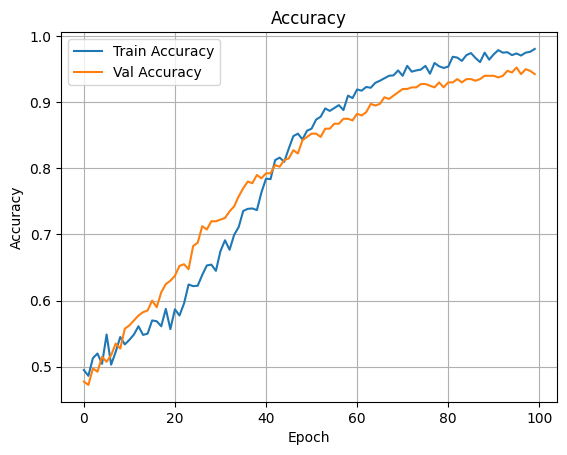

In [14]:
#Train Accuracy, Val Accuracy 비교
plt.plot(history_5.history['accuracy'], label='Train Accuracy')
plt.plot(history_5.history['val_accuracy'], label='Val Accuracy')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

### Step 6. 모델 성능 비교 및 시각화
* Step 5.를 통해 학습된 모델들을 테스트 데이터셋을 통해 평가하고 그 결과를 서로 비교하여 원하는 결과에 도달했는지를 검증
* 평가 정확도는 각 모델의 마지막 부분에 작성하였으며, 이들의 값을 저장해 현 코드에서 한눈에 비교

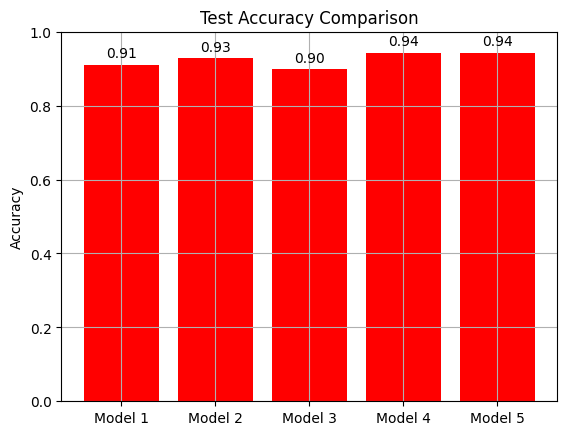

In [18]:

test_accs = [accuracy_type1, accuracy_type2, accuracy_type3, accuracy_type4, accuracy_type5]
model_names = ["Model 1", "Model 2", "Model 3", "Model 4", "Model 5"]

for i, acc in enumerate(test_accs):
    plt.text(i, acc + 0.02, f"{acc:.2f}", ha='center')

plt.bar(model_names, test_accs, color = "red")
plt.title("Test Accuracy Comparison")
plt.ylabel("Accuracy")
plt.ylim(0, 1)
plt.grid(True)
plt.show()